# Part I: Replicating Models from Class

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from math import e
from scipy.optimize import minimize
from scipy.stats import poisson
from scipy.special import gamma
from scipy.special import gammaln
from scipy.special import factorial

### Question 1: Consider the example related to billboard exposures from class. The associated data is in the file billboard.csv. Write code to estimate the parameters of the Poisson model using maximum likelihood estimation (MLE). Report your code, the estimated parameters and the maximum value of the log-likelihood. Predict the number of people with 0, …, 23 exposures based on the Poisson model. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted number of exposures (number of people on the y-axis and the number of exposures on the x-axis) 

In [2]:
# Reading the dataset
bb_exp = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/billboard.csv')
bb_exp

,EXPOSURES,PEOPLE
0,0,48
1,1,37
2,2,30
3,3,24
4,4,20
5,5,16
6,6,13
7,7,11
8,8,9
9,9,7


In [3]:
# Defining the log-likelihood function
def LL_p(params, e, p):
    l = params
    prob = []
    ll = []
    
    for i in range(len(e)):
        if i == 0:
            prob.append(math.exp(-l))
        else:
            prob.append(((l**i)*(math.exp(-l)))/math.factorial(i))
        ll.append(p[i] * math.log(prob[i]))
    return ll

In [4]:
# Defining the negative log-likelihood function
def NLL_p(params, e, p):
    return(-np.sum(LL_p(params, e, p)))

In [5]:
# Setting up the parameters
params = np.array((0.5))
e = np.array(bb_exp.EXPOSURES)
p = np.array(bb_exp.PEOPLE)

In [6]:
# Minimizing the negative log likelihood function
soln_p = minimize(
    NLL_p,
    args = (e, p),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [7]:
# Printing the solution
soln_p

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 929.0438827273031
        x: [ 4.456e+00]
      nit: 9
      jac: [-3.411e-05]
     nfev: 20
     njev: 10
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [8]:
# Looking at the optimal value of lambda (l)
l1 = soln_p.x[0]
l1

4.4559993693051325

In [9]:
# Maximum value of log-likelihood 
ll_poi = -soln_p.fun
ll_poi

-929.0438827273031

In [10]:
# Predicting the number of people given exposure for the week data we have.
def predict_p(op_l, e, people):
    predP = []
    for i in range(len(e)):
        pred = ((math.exp(-op_l) * (op_l ** i)) / math.factorial(i)) * people
        predP.append(pred)
    return predP

In [11]:
# Printing the predicted values
preds = predict_p(l1, e, np.sum(p))

In [12]:
# Calculate for 2 exposures
e2 = bb_exp.EXPOSURES[2]
p2 = bb_exp.PEOPLE[2]
pred2 = (math.exp(-l1) * (l1 ** e2)) / math.factorial(e2) * 250
pred2

28.812723857097705

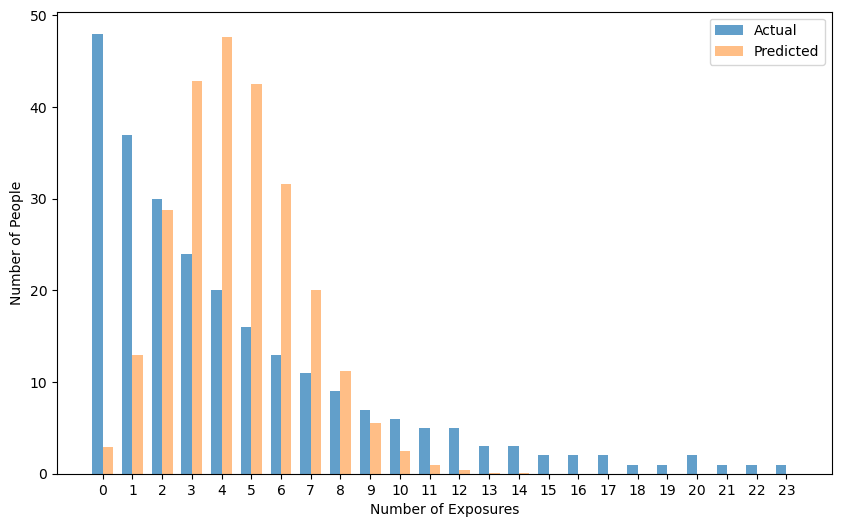

In [13]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(len(e))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], p, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], preds, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Exposures")
plt.ylabel("Number of People")
plt.xticks(x, e)
plt.legend()
plt.show()

### Question 2: Next, write code (for the same dataset) to estimate the parameters of the NBD model using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. Evaluate the NBD model vis-à-vis the Poisson model; explain which is better and why. Predict the number of people with 0, …, 23 exposures based on the NBD model. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted numbers of exposures. 

In [14]:
# Defining the recursive function for k > 0
def nbd(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [15]:
# Defining the log-likelihood function
def LL_nbd(params, e, people):
    n, a = params
    pmf = np.zeros(len(e))
    pmf[0] = (a / (a + 1)) ** n
    ll_nbd = people[0] * np.log(pmf[0])
    
    for k in range(1, len(e)):
        pmf[k] = nbd(k, n, a, pmf[k - 1])
        ll_nbd += people[k] * np.log(pmf[k])
    
    return -ll_nbd

In [16]:
# Passing the parameters
params = np.array([1.0, 0.5])
exposures = np.array(bb_exp.EXPOSURES)
people = np.array(bb_exp.PEOPLE)

In [17]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd = minimize(
    LL_nbd,
    args=(exposures, people),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

In [18]:
# Printing the optimal n and a values
optimal_n, optimal_a = soln_nbd.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")

Optimal n: 0.9692642014951004
Optimal a: 0.21752139825750305


In [19]:
# Maximum value of log-likelihood 
ll_nbd = -soln_nbd.fun
ll_nbd

-649.6888274977052

In [20]:
def predict_nbd(params, e, total_people):
    n, a = params
    predictions = np.zeros(len(e))
    predictions[0] = (a / (a + 1)) ** n
    
    for k in range(1, len(e)):
        predictions[k] = nbd(k, n, a, predictions[k - 1])
    
    # Scale the predictions to the total number of people
    scaled_predictions = predictions * total_people
    
    return scaled_predictions

# Total numbe of people in the dataset
total_people = np.sum(people)

# Use the fitted parameters to make predictions and scale them to total people
optimal_params = (optimal_n, optimal_a)
predicted_people = predict_nbd(optimal_params, exposures, total_people)

In [21]:
predicted_people

array([47.09285164, 37.49044189, 30.31921461, 24.6472762 , 20.08826112,
       16.39788459, 13.39925875, 10.95703527,  8.96488442,  7.33807928,
        6.00853925,  4.92126908,  4.03168614,  3.30355923,  2.70739106,
        2.21913428,  1.81916421,  1.49145238,  1.22289896,  1.002792  ,
        0.82236823,  0.67445599,  0.5531843 ,  0.45374567])

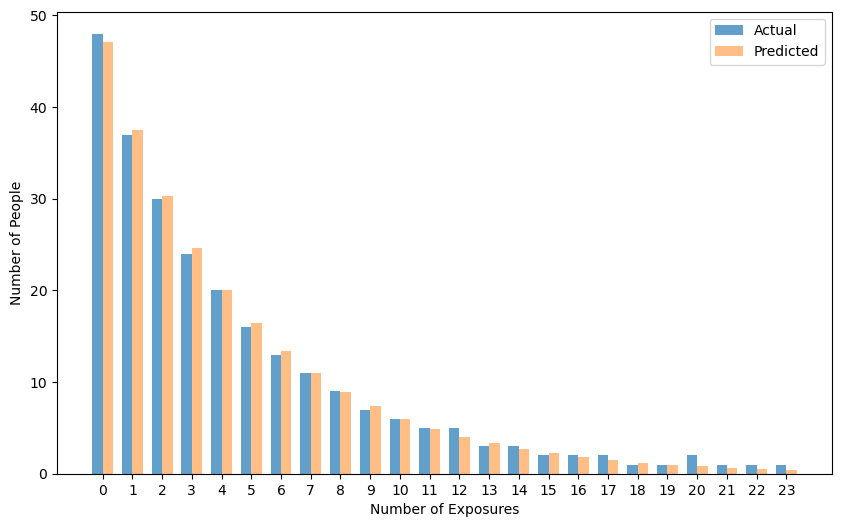

In [22]:
# Plotting the actual and predicted histograms.

bar_width = 0.35
x = range(len(exposures))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Exposures")
plt.ylabel("Number of People")
plt.xticks(x, exposures)
plt.legend()
plt.show()

### Question 3: Now consider the khakichinos example from class; The associated data is in the file khakichinos.csv. Estimate all relevant parameters for Poisson regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. Predict the number of people with 0, …, 23 exposures based on the Poisson regression. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted numbers of exposures. 

In [23]:
# Reading the dataset.
kch = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/khakichinos.csv')
kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize
0,1,0,11.379394,1,3.871201,2
1,2,5,9.769956,1,4.043051,1
2,3,0,11.082143,0,3.332205,2
3,4,0,10.915088,1,3.951244,3
4,5,0,10.915088,1,2.833213,3
...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2
2724,2725,0,11.379394,0,3.970292,2
2725,2726,0,11.191342,1,3.044522,3
2726,2727,0,10.532096,1,2.890372,4


In [24]:
# Defining the log-likelihood function
def LL_pr(params, v, x1, x2, x3, x4):
    l0, b1, b2, b3, b4 = params
    li = []
    for i in range(len(v)):
        li.append(l0*np.exp(b1*x1[i] + b2*x2[i] + b3*x3[i] + b4*x4[i]))
       
    #prob_pr = []
    ll = []
    
    for i in range(len(v)):
            ll_1 = v[i]*np.log(li[i])
            ll_2 = (li[i])
            ll_3a = np.math.factorial(v[i])
            ll_3 = np.log(float(ll_3a))
            ll.append(ll_1-ll_2-ll_3)

    return ll


In [25]:
# Defining the negative log-likelihood function
def NLL_pr(params, v, x1, x2, x3, x4):
    return(-np.sum(LL_pr(params, v, x1, x2, x3, x4)))

In [26]:
# Setting up the parameters
params = np.array([0.5, 0.1, 0.2, 0.5, -0.3])
v = np.array(kch.NumberofVisits)
x1 = np.array(kch.LnInc)
x2 = np.array(kch.Sex)
x3 = np.array(kch.LnAge)
x4 = np.array(kch.HHSize)

In [27]:
# Minimizing the Negative Log-Likelihood of the model established.
soln_pr = minimize(
    NLL_pr, 
    args=(v, x1, x2, x3, x4),
    x0=np.array((1,0.2,0.3,0.1,-0.3)),
    bounds=[(0.00000001,None),(None,None),(None,None),(None,None),(None,None)],
    tol=1e-10,
    options={'ftol':1e-8}
)

In [28]:
# 
soln_pr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6291.496747493691
        x: [ 4.389e-02  9.383e-02  4.268e-03  5.882e-01 -3.590e-02]
      nit: 82
      jac: [-1.389e-01 -6.221e-02  4.729e-03 -4.547e-02  5.384e-02]
     nfev: 630
     njev: 105
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [29]:
# Printing the optimal parameters
optimal_l0, optimal_b1, optimal_b2, optimal_b3, optimal_b4 = soln_pr.x
print(f"Optimal l0: {optimal_l0}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")

Optimal l0: 0.04388559117134688
Optimal b1: 0.09383433292308603
Optimal b2: 0.004267656996633129
Optimal b3: 0.5882009941783403
Optimal b4: -0.035896514680631444


In [30]:
# Maximum value of log-likelihood 
ll_pr = -soln_pr.fun
ll_pr

-6291.496747493691

In [31]:
# !!!!!! DOUBT!!!!!!
def pred_pr(v, x1, x2, x3, x4):
    predPr = []
    li = []
    for i in range(len(v)):
        li.append(optimal_l0*np.exp(optimal_b1*x1[i] + optimal_b2*x2[i] + optimal_b3*x3[i] + optimal_b4*x4[i]))
        
    for j in range(len(v)):
        pred = ((math.exp(-li[j]) * (li[j] ** v[j])) / math.factorial(v[j]))
        predPr.append(pred)
    return predPr


In [32]:
# 
v = np.array(kch.NumberofVisits)
x1 = np.array(kch.LnInc)
x2 = np.array(kch.Sex)
x3 = np.array(kch.LnAge)
x4 = np.array(kch.HHSize)

In [33]:
# 
preds = pred_pr(v, x1, x2, x3, x4)

In [34]:
# 
preds

[0.3125018202345511,
 0.005252828921320488,
 0.44029436205408273,
 0.32430136224352896,
 0.5579979275778068,
 0.5378413708223405,
 0.365274715762447,
 0.3497789333164932,
 0.2672725205457666,
 0.34765203322154065,
 0.364884486576768,
 0.30472133505899507,
 0.053169321338248005,
 0.3729965518622565,
 0.42744172409505504,
 0.3529155707768152,
 0.20265189575579812,
 0.3177822751078715,
 0.0002008614731644419,
 0.40864021615574575,
 0.1316361041820451,
 0.40644257204712003,
 0.41326937598024216,
 0.2105969754283762,
 0.2298942378592264,
 0.27379496358603983,
 0.4441735072126151,
 0.2737306778309934,
 0.3554836868562769,
 0.41755809621856127,
 0.4275590948845844,
 0.5325858680818871,
 0.45608385032129845,
 0.47866262719603686,
 0.4204047521589676,
 0.3098284777821941,
 0.17205858517491995,
 0.203849298127279,
 0.34568554641429694,
 0.6213367678049881,
 0.34972213012944775,
 0.2713253363746857,
 0.26302941688307396,
 0.4617235049789649,
 0.46190796879332807,
 0.4211405005746593,
 0.503876645

In [35]:
pred_kch = kch.copy()
pred_kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize
0,1,0,11.379394,1,3.871201,2
1,2,5,9.769956,1,4.043051,1
2,3,0,11.082143,0,3.332205,2
3,4,0,10.915088,1,3.951244,3
4,5,0,10.915088,1,2.833213,3
...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2
2724,2725,0,11.379394,0,3.970292,2
2725,2726,0,11.191342,1,3.044522,3
2726,2727,0,10.532096,1,2.890372,4


In [36]:
import pandas as pd

# Create a Pandas Series from the list `preds`.
preds_series = pd.Series(preds, name='preds')

# Insert the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_kch.insert(loc=len(pred_kch.columns), column='preds', value=preds_series)


In [37]:
pred_kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize,preds
0,1,0,11.379394,1,3.871201,2,0.312502
1,2,5,9.769956,1,4.043051,1,0.005253
2,3,0,11.082143,0,3.332205,2,0.440294
3,4,0,10.915088,1,3.951244,3,0.324301
4,5,0,10.915088,1,2.833213,3,0.557998
...,...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2,0.567305
2724,2725,0,11.379394,0,3.970292,2,0.292965
2725,2726,0,11.191342,1,3.044522,3,0.507652
2726,2727,0,10.532096,1,2.890372,4,0.570338


In [38]:
indices = np.where(pred_kch['NumberofVisits'] == 0)[0]
len(indices)

2046

In [39]:
pred_0 = pred_kch.loc[indices, 'preds'].sum()
pred_0

832.0143578817579

In [40]:
import pandas as pd

# Create a new column called 'log_preds' and assign it the log of the 'preds' column.
pred_kch['log_preds'] = np.log(pred_kch['preds'])


In [41]:
pred_kch

,ID,NumberofVisits,LnInc,Sex,LnAge,HHSize,preds,log_preds
0,1,0,11.379394,1,3.871201,2,0.312502,-1.163145
1,2,5,9.769956,1,4.043051,1,0.005253,-5.248989
2,3,0,11.082143,0,3.332205,2,0.440294,-0.820312
3,4,0,10.915088,1,3.951244,3,0.324301,-1.126082
4,5,0,10.915088,1,2.833213,3,0.557998,-0.583400
...,...,...,...,...,...,...,...,...
2723,2724,0,9.528794,1,2.944439,2,0.567305,-0.566859
2724,2725,0,11.379394,0,3.970292,2,0.292965,-1.227703
2725,2726,0,11.191342,1,3.044522,3,0.507652,-0.677959
2726,2727,0,10.532096,1,2.890372,4,0.570338,-0.561527


In [42]:
unique_visits = np.unique(kch.NumberofVisits)
unique_visits

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 20, 21, 22, 25, 26, 27, 28, 33, 34, 36, 40, 42, 49, 50, 62, 79])

In [43]:
visit_count = {}
for visit in unique_visits:
    visit_count[visit] = 0

for i in range(len(kch)):
    visit = kch.loc[i, 'NumberofVisits']
    visit_count[visit] += 1


for visit, count in visit_count.items():
    print('Number of visits: {} | Count of people: {}'.format(visit, count))

Number of visits: 0 | Count of people: 2046
Number of visits: 1 | Count of people: 318
Number of visits: 2 | Count of people: 129
Number of visits: 3 | Count of people: 66
Number of visits: 4 | Count of people: 38
Number of visits: 5 | Count of people: 30
Number of visits: 6 | Count of people: 16
Number of visits: 7 | Count of people: 11
Number of visits: 8 | Count of people: 9
Number of visits: 9 | Count of people: 10
Number of visits: 10 | Count of people: 5
Number of visits: 11 | Count of people: 6
Number of visits: 12 | Count of people: 5
Number of visits: 14 | Count of people: 4
Number of visits: 15 | Count of people: 3
Number of visits: 16 | Count of people: 8
Number of visits: 17 | Count of people: 1
Number of visits: 18 | Count of people: 2
Number of visits: 20 | Count of people: 1
Number of visits: 21 | Count of people: 2
Number of visits: 22 | Count of people: 2
Number of visits: 25 | Count of people: 3
Number of visits: 26 | Count of people: 1
Number of visits: 27 | Count of

### Question 4:  The NBD Regression: Consider the khakichinos example again. Estimate all relevant parameters for NBD regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. Evaluate the NBD regression vis-à-vis the Poisson regression; explain which is better and why. Predict the number of people with 0, …, 23 exposures based on the NBD regression. Explain how the predicted values are obtained using the case of 2 exposures (show your calculations). Graph the original and predicted numbers of exposures.

In [60]:
# Setting up the parameters.
y = np.array(kch['NumberofVisits'])
x1= np.array(kch['LnInc'])
x2= np.array(kch['Sex'])
x3= np.array(kch['LnAge'])
x4= np.array(kch['HHSize'])

In [61]:
# Defining the NBD-regression Log Likelihood fucntion

def NBDReg(params,x1,x2,x3,x4,y):
    n,alpha,nbeta1, nbeta2, nbeta3, nbeta4= params
    nll=0
    nll1=0
    nll2=0
    nll3=0
    nll4=0
    for i in range(len(x1)):
        beta=math.exp(nbeta1*x1[i]+nbeta2*x2[i]+nbeta3*x3[i]+nbeta4*x4[i])
        nll1=nll1+np.log(math.gamma(n+int(y[i])))
        nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(y[i])))
        nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
        nll4=nll4+int(y[i])*(np.log(beta)-np.log(alpha+beta))
    nll=nll1-nll2+nll3+nll4
    return nll*(-1)
    

In [62]:
NBD_result=minimize(NBDReg,  args=(x1,x2,x3,x4,y),x0=np.array((1,1,0.2,0.3,0.1,-0.3)),bounds=[(0.00000001,None),(0.00000001,None),(None,None),(None,None),(None,None),(None,None)],tol=1e-10,options={'ftol':1e-8})
n = NBD_result.x[0]
alpha=NBD_result.x[1]
beta1 = NBD_result.x[2]
beta2 = NBD_result.x[3]
beta3 = NBD_result.x[4]
beta4 = NBD_result.x[5]

In [63]:
nll=0
nll1=0
nll2=0
nll3=0
nll4=0

for i in range(len(x1)):
    beta=math.exp(beta1*x1[i]+beta2*x2[i]+beta3*x3[i]+beta4*x4[i])
    nll1=nll1+np.log(math.gamma(n+int(y[i])))
    nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(y[i])))
    nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
    nll4=nll4+int(y[i])*(np.log(beta)-np.log(alpha+beta))
nll=nll1-nll2+nll3+nll4

In [65]:
# Looking into the solution
NBD_result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2888.966117052838
        x: [ 1.388e-01  8.177e+00  7.321e-02 -9.275e-03  9.021e-01
            -2.436e-02]
      nit: 81
      jac: [ 3.083e-02 -1.364e-04 -2.456e-02 -1.273e-03 -5.184e-03
            -2.879e-02]
     nfev: 672
     njev: 96
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [66]:
print("n: {}".format(n))
print("alpha:{}".format(alpha))
print("beta1: {}".format(beta1))
print("beta2: {}".format(beta2))
print("beta3: {}".format(beta3))
print("beta4: {}".format(beta4))
print("log likelihood: {}".format(nll))

n: 0.13875193522417364
alpha:8.176710031415167
beta1: 0.07321150220946064
beta2: -0.00927489555886401
beta3: 0.9020673215315569
beta4: -0.02435922197887667
log likelihood: -2888.966117052838


In [48]:
# Printing out the optimal parameters.
optimal_n, optimal_a, optimal_b1, optimal_b2, optimal_b3, optimal_b4 = soln_nbdr.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")

NameError: name 'soln_nbdr' is not defined

In [49]:
# Pritnting the maximum value of the Log-likelihood.
nbdr_mll = soln_nbdr.fun
-nbdr_mll

NameError: name 'soln_nbdr' is not defined

In [ ]:
# !!!! DOUBT !!! Predictions.

# Part II: Analysis of New Data 

### Question 1: Read books.csv and generate two new datasets – (a): books01.csv, with the structure of the dataset used in the billboard exposures example (i.e., with only two columns – (i) the number purchases, and (ii) the number of people making the corresponding number of purchases), and (b): books02.csv, with the structure of the dataset used in the khakichinos example, with a new column containing a count of the number of books purchased from barnesandnoble.com by each customer, while keeping the demographic variables (remember to drop date, product, and price). Print the first and last 10 records of both new datasets.

### 1(a): 

In [2]:
# Reading the dataset
books = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/books.csv')
books = books.drop(['date', 'product', 'price'], axis = 1)
books

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
0,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,1
1,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,1
2,11443031,4.0,1.0,2,11.0,4,1,1,0,amazon.com,1
3,11519009,NaN,2.0,3,5.0,3,1,2,0,amazon.com,1
4,11519009,NaN,2.0,3,5.0,3,1,2,0,amazon.com,1
...,...,...,...,...,...,...,...,...,...,...,...
40940,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1
40941,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1
40942,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1
40943,15557019,NaN,2.0,3,6.0,6,1,1,0,amazon.com,1


In [3]:
# Taking the dataset limited to only the Barnes and Noble domain.
ban = books[books['domain'] == 'barnesandnoble.com']
ban

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
19,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
20,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
21,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
45,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
46,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
...,...,...,...,...,...,...,...,...,...,...,...
40932,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40933,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40934,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40935,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1


In [4]:
all_customers = books['userid'].unique()
len(all_customers)

9451

In [5]:
amazon_visitors = set(books[books['domain'] == 'amazon.com']['userid'])

# Finding customers who visited 'barnesandnoble.com'
barnesandnoble_visitors = set(books[books['domain'] == 'barnesandnoble.com']['userid'])

# Find customers who ONLY visited 'amazon.com'
only_amazon_visitors = amazon_visitors - barnesandnoble_visitors

only_amazon_visitors_list = list(only_amazon_visitors)

# Printing the number of customers who never visited barnesandnoble.com
print(f"Number of customers who never visited barnesandnoble.com': {len(only_amazon_visitors_list)}")


Number of customers who never visited barnesandnoble.com': 7639


In [6]:
len(barnesandnoble_visitors)

1812

In [7]:
# Looking into the total number of purchases made by each user, grouped by the userid.
purchases_by_userid = ban.groupby('userid')['qty'].sum()
purchases_by_userid

userid
6365661     1
6396922     1
8999933     1
9573834     2
9576277     5
           ..
15695968    5
15696910    2
15698055    9
15698341    2
15698605    1
Name: qty, Length: 1812, dtype: int64

In [8]:
# Taking the purchases as a separate array
total_purchases = purchases_by_userid.values
total_purchases

array([1, 1, 1, ..., 9, 2, 1])

In [9]:
# Taking in the unique values in the purchases array.
unique_purchases = np.unique(total_purchases)
unique_purchases

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  37,  39,  43,  46,  47,  50,  56,
        58,  62,  63,  83,  86, 111])

In [10]:

books01 = purchases_by_userid.value_counts().reset_index()
books01.columns = ['PURCHASES', 'PEOPLE']
data = {'PURCHASES': [0], 'PEOPLE': [7639]}
new_row = pd.DataFrame(data)

# Append the new row to the existing DataFrame
books01 = books01.append(new_row, ignore_index=True)

books01 = books01.sort_values(by='PURCHASES')

# Display the resulting DataFrame
books01


/var/folders/9n/6229qxsn2nb0ccgf0xrsgxb00000gp/T/ipykernel_1856/800467981.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  books01 = books01.append(new_row, ignore_index=True)


,PURCHASES,PEOPLE
45,0,7639
0,1,753
1,2,362
2,3,175
3,4,126
4,5,82
5,6,74
8,7,30
6,8,48
7,9,31


In [11]:
books01.to_csv('books01.csv', index=False)

In [12]:
books01.head(10)

,PURCHASES,PEOPLE
45,0,7639
0,1,753
1,2,362
2,3,175
3,4,126
4,5,82
5,6,74
8,7,30
6,8,48
7,9,31


In [13]:
books01.tail(10)

,PURCHASES,PEOPLE
35,46,1
38,47,1
36,50,1
34,56,1
31,58,1
29,62,1
42,63,1
30,83,1
40,86,1
43,111,1


### 1(b): books02.csv, with the structure of the dataset used in the khakichinos example, with a new column containing a count of the number of books purchased from barnesandnoble.com by each customer, while keeping the demographic variables (remember to drop date, product, and price). Print the first and last 10 records of the new dataset.

In [41]:
ban_visitors= set(books[books['domain'] == 'barnesandnoble.com']['userid'])
len(ban_visitors)

1812

In [42]:
ama_visitors = set(books[books['domain'] == 'amazon.com']['userid'])
ama_visitors

{13828099,
 13041670,
 14909447,
 12714002,
 15499284,
 14581790,
 14909476,
 15564840,
 15335470,
 15401008,
 14581814,
 15433784,
 14680122,
 14549052,
 14417983,
 14647359,
 15597642,
 15106127,
 14549072,
 15532113,
 9896018,
 13959256,
 15401050,
 15695968,
 10256481,
 12746852,
 14647399,
 15269993,
 15007849,
 14221421,
 12976244,
 14549115,
 13238398,
 14549120,
 10420353,
 12943494,
 15466636,
 14385292,
 15401104,
 15564948,
 15466646,
 11436184,
 14123161,
 14385306,
 14647451,
 9765019,
 14581914,
 15237282,
 14581922,
 12910757,
 15007913,
 13435056,
 14549175,
 13402298,
 14385341,
 14221503,
 13172932,
 13238472,
 13107402,
 13369547,
 15597773,
 15433933,
 9863382,
 13369561,
 15696094,
 9765091,
 15597799,
 13205738,
 12026091,
 14811374,
 14516463,
 14647541,
 14582009,
 12910848,
 14713089,
 15008011,
 12878092,
 14549265,
 14549266,
 10682647,
 15597850,
 13402396,
 14680355,
 12943652,
 13828391,
 14582055,
 15302953,
 13599025,
 14549303,
 14811452,
 13926717,
 13

In [43]:
only_ama_visitors = ama_visitors- ban_visitors
only_ama_visitors = list(only_ama_visitors)
print(f"Number of customers who Only visited Amazon.com: {len(only_ama_visitors)}")

Number of customers who Only visited Amazon.com: 7639


In [44]:
only_amazon =[]
for id in only_ama_visitors:
    select_rows= books[books['userid'] == id].iloc[0]
    only_amazon.append(select_rows )
 

In [45]:
amazon_only = pd.DataFrame(only_amazon, columns=['userid', 'education', 'region', 'hhsz', 'age', 'income','child','race','country', 'domain', 'qty'])
amazon_only

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
18566,14565378,NaN,4.0,2,6.0,6,0,1,0,amazon.com,1
11805,13828099,1.0,1.0,4,4.0,7,1,1,1,amazon.com,1
29311,15679490,5.0,3.0,2,10.0,5,1,1,0,amazon.com,1
30905,13041670,NaN,4.0,5,9.0,1,0,1,1,amazon.com,1
33869,14893062,NaN,2.0,5,6.0,6,1,1,0,amazon.com,1
...,...,...,...,...,...,...,...,...,...,...,...
30976,14794736,NaN,3.0,5,9.0,7,1,1,0,amazon.com,1
10406,14680050,NaN,2.0,2,10.0,7,0,1,0,amazon.com,1
29346,13795324,NaN,3.0,2,5.0,1,0,1,1,amazon.com,1
29814,14303229,NaN,1.0,3,10.0,7,1,1,1,amazon.com,1


In [46]:
# making sure there are no barned and nobles entries in only amazon visitors df
# use a boolean mask to count occurrences 
mask = amazon_only['domain'] == 'barnesandnoble.com'
count = len(amazon_only[mask])
print(count)

0


In [47]:
only_ban =[]
only_ban = books[(books['userid'].isin(ban_visitors)) & (books['domain'] == 'barnesandnoble.com')]

In [48]:
# converting the list to DF
ban_only = pd.DataFrame(only_ban, columns=['userid', 'education', 'region', 'hhsz', 'age', 'income','child','race','country', 'domain', 'qty'])
ban_only

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
19,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
20,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
21,13503636,4.0,3.0,4,8.0,7,1,1,1,barnesandnoble.com,1
45,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
46,14559596,NaN,4.0,2,10.0,5,1,1,0,barnesandnoble.com,1
...,...,...,...,...,...,...,...,...,...,...,...
40932,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40933,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40934,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40935,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1


In [49]:
# checking if any amazon entries in this file
mask2 = ban_only['domain'] == 'amazon.com'
count = len(ban_only[mask2])
print(count)

0


In [50]:
# manually changing quantity in ama_only to 0 as they are not barnesandnobles visitors
amazon_only['qty']=0
amazon_only
 

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
18566,14565378,NaN,4.0,2,6.0,6,0,1,0,amazon.com,0
11805,13828099,1.0,1.0,4,4.0,7,1,1,1,amazon.com,0
29311,15679490,5.0,3.0,2,10.0,5,1,1,0,amazon.com,0
30905,13041670,NaN,4.0,5,9.0,1,0,1,1,amazon.com,0
33869,14893062,NaN,2.0,5,6.0,6,1,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...,...
30976,14794736,NaN,3.0,5,9.0,7,1,1,0,amazon.com,0
10406,14680050,NaN,2.0,2,10.0,7,0,1,0,amazon.com,0
29346,13795324,NaN,3.0,2,5.0,1,0,1,1,amazon.com,0
29814,14303229,NaN,1.0,3,10.0,7,1,1,1,amazon.com,0


In [51]:
# concatenating amazon_only and ban_only df to form books_2
# Concatenate along the rows (axis=0)
books02 = pd.concat([amazon_only, ban_only])

In [52]:
books02.to_csv('books02.csv', index=False)

In [53]:
books02.head(10)

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
18566,14565378,NaN,4.0,2,6.0,6,0,1,0,amazon.com,0
11805,13828099,1.0,1.0,4,4.0,7,1,1,1,amazon.com,0
29311,15679490,5.0,3.0,2,10.0,5,1,1,0,amazon.com,0
30905,13041670,NaN,4.0,5,9.0,1,0,1,1,amazon.com,0
33869,14893062,NaN,2.0,5,6.0,6,1,1,0,amazon.com,0
16558,14925837,NaN,3.0,1,11.0,5,0,1,0,amazon.com,0
9951,12714002,2.0,4.0,2,11.0,7,0,1,0,amazon.com,0
36624,15499284,1.0,3.0,2,5.0,4,0,1,0,amazon.com,0
5518,14467095,NaN,1.0,3,10.0,7,1,1,0,amazon.com,0
6411,15220763,NaN,1.0,2,9.0,6,1,1,0,amazon.com,0


In [54]:
books02.tail(10)

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
40926,15388955,4.0,3.0,3,7.0,5,1,1,0,barnesandnoble.com,1
40927,15388955,4.0,3.0,3,7.0,5,1,1,0,barnesandnoble.com,1
40928,15514646,5.0,1.0,3,11.0,2,1,1,0,barnesandnoble.com,1
40929,15514646,5.0,1.0,3,11.0,2,1,1,0,barnesandnoble.com,1
40931,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40932,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40933,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40934,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40935,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1
40936,15541746,NaN,1.0,4,6.0,3,1,1,0,barnesandnoble.com,1


In [55]:
# group by id's
# Looking into the total number of purchases made by each user, grouped by the userid.
books02 = books02.groupby('userid').agg({'education': 'first', 'region': 'first', 'hhsz': 'first', 'age': 'first',
                                           'income': 'first', 'child': 'first', 'race': 'first', 'country': 'first',
                                           'domain': 'first',
                                           'qty': 'sum'}).reset_index()
 
books02

,userid,education,region,hhsz,age,income,child,race,country,domain,qty
0,6365661,5.0,1.0,2,11.0,7,0,1,0,barnesandnoble.com,1
1,6388054,2.0,4.0,1,6.0,5,0,1,0,amazon.com,0
2,6396922,2.0,2.0,2,8.0,4,0,1,0,barnesandnoble.com,1
3,6421559,5.0,4.0,4,5.0,6,0,1,0,amazon.com,0
4,6467806,NaN,2.0,2,6.0,3,0,1,0,amazon.com,0
...,...,...,...,...,...,...,...,...,...,...,...
9446,15701290,NaN,1.0,2,3.0,3,0,1,0,amazon.com,0
9447,15701618,NaN,2.0,3,7.0,2,0,1,0,amazon.com,0
9448,15701673,NaN,4.0,5,5.0,3,1,1,1,amazon.com,0
9449,15701704,NaN,3.0,3,5.0,7,1,1,0,amazon.com,0


In [56]:
#ban2 = books[books['domain'] == 'barnesandnoble.com']
#ban2
len(books02)

9451

### Question 2: Develop a Poisson model using books01.csv. Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant). 

In [18]:
def LL_p2(params, pur, peo):
    l = params
    prob = []
    ll = []
    purc_a = np.array(books01.PURCHASES)
    for i in range(len(purc_a)):
        prob.append(((l**pur[i])*(math.exp(-l)))/math.factorial(pur[i]))
        ll.append(peo[i] * math.log(prob[i]))
    return ll

In [19]:
# Defining the negative log-likelihood function
def NLL_p2(params, pur, peo):
    return(-np.sum(LL_p2(params, pur, peo)))

In [20]:
# Setting up the parameters
params = np.array((0.5))
pur = np.array(books01.PURCHASES)
peo = np.array(books01.PEOPLE)

In [21]:
# Minimizing the negative log likelihood function
soln_p2 = minimize(
    NLL_p2,
    args = (pur, peo),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [22]:
# Looking into the solution
soln_p2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18921.91842943338
        x: [ 7.485e-01]
      nit: 5
      jac: [-3.638e-04]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [23]:
# Getting the value of lambda in this case
l2 = soln_p2.x[0]
l2

0.7484921842401744

In [24]:
# Maximum value of log-likelihood 
mll_2 = -soln_p2.fun
mll_2

-18921.91842943338

In [27]:
# Predicting the number of people given number of purchases for the week data we have.
def predict_p2(op_l, purc, people):
    predP = []
    for i in range(len(purc)):
        pred = ((math.exp(-op_l) * (op_l ** i)) / math.factorial(i)) * people
        predP.append(pred)
    return predP

In [28]:
# Predicting the number of people given exposure for the week data we have.
preds_2 = predict_p2(l2, pur, np.sum(peo))

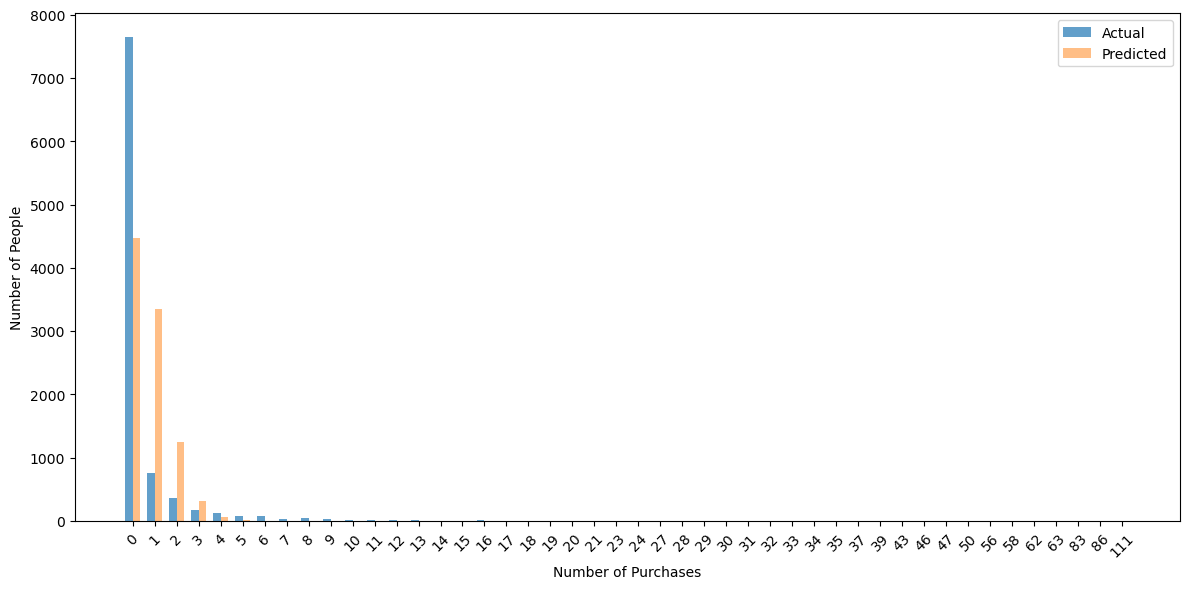

In [39]:
# Plotting the actual and predicted histograms.
bar_width = 0.35
x = range(len(pur))

plt.figure(figsize=(12, 6))  # Increase the figure width to create more space

plt.bar([i - bar_width/2 for i in x], peo, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], preds_2, bar_width, alpha=0.5, label="Predicted", color="tab:orange")

plt.xticks([i for i in x], pur, rotation=45)

plt.xlabel("Number of Purchases")
plt.ylabel("Number of People")
plt.legend()
plt.tight_layout()
plt.show()


### Question 3:  Develop a Poisson model using books02.csv, i.e., by ignoring the independent variables available. Report your code and confirm that the estimated parameters and the maximum value of the log-likelihood are identical to those obtained with the Poisson model developed using books01.csv.

In [57]:
b2 = books02.copy()
b2 = b2.drop(['education', 'region', 'hhsz', 'age', 'income', 'child', 'race', 'country', 'domain'], axis=1)
b2

,userid,qty
0,6365661,1
1,6388054,0
2,6396922,1
3,6421559,0
4,6467806,0
...,...,...
9446,15701290,0
9447,15701618,0
9448,15701673,0
9449,15701704,0


In [58]:
def LL_pb2(params, pur):
    l = params
    prob = []
    ll = []
    purc_a = np.array(books02.qty)
    for i in range(len(purc_a)):
        prob.append(((l**pur[i])*(math.exp(-l)))/math.factorial(pur[i]))
        ll.append(1 * math.log(prob[i]))
    return ll

In [59]:
# Defining the negative log-likelihood function
def NLL_pb2(params, pur):
    return(-np.sum(LL_pb2(params, pur)))

In [60]:
# Setting up the parameters
params = np.array((0.5))
pur = np.array(b2.qty)

In [61]:
soln_pb2 = minimize(
    NLL_pb2,
    args = (pur),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [62]:
soln_pb2

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 18921.918429433368
        x: [ 7.485e-01]
      nit: 5
      jac: [ 0.000e+00]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [63]:
# Getting the value of lambda in this case
lb2 = soln_pb2.x[0]
lb2

0.7484922155186616

In [64]:
# Maximum value of log-likelihood 
mlp_2 = -soln_pb2.fun
mlp_2

-18921.918429433368

### Question 4: Develop an NBD model using books01.csv. Report your code, the estimated parameters and the maximum value of the log-likelihood (and any other information you believe is relevant).

In [30]:
# 
def nbd(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [31]:
# Defining the log-likelihood function
def LL_nbd(params, pur, peo):
    n, a = params
    pmf = np.zeros(len(pur))
    pmf[0] = (a / (a + 1)) ** n
    ll_nbd = peo[0] * np.log(pmf[0])
    
    for k in range(1, len(pur)):
        pmf[k] = nbd(k, n, a, pmf[k - 1])
        ll_nbd += peo[k] * np.log(pmf[k])
    
    return -ll_nbd

In [32]:
# Passing the parameters
params = np.array([1.0, 0.5])
pur = np.array(books01.PURCHASES)
peo = np.array(books01.PEOPLE)

In [33]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd = minimize(
    LL_nbd,
    args=(pur, peo),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

In [34]:
soln_nbd

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8329.449038385643
        x: [ 1.014e-01  1.426e-01]
      nit: 15
      jac: [ 4.566e-02 -2.001e-02]
     nfev: 81
     njev: 27
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [35]:
# Printing the optimal n and a values
optimal_n, optimal_a = soln_nbd.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")

Optimal n: 0.10138854653491085
Optimal a: 0.14261347105530242


In [36]:
# Seeing the maximum value of log-likelihood.
ll_nbd2 = -soln_nbd.fun
ll_nbd2

-8329.449038385643

In [37]:
# Predicting number of people against given number of purchases.
def predict_nbd2(params, pur, total_people):
    n, a = params
    predictions = np.zeros(len(pur))
    predictions[0] = (a / (a + 1)) ** n
    
    for k in range(1, len(pur)):
        predictions[k] = nbd(k, n, a, predictions[k - 1])
    
    # Scale the predictions to the total number of people
    scaled_predictions = predictions * total_people
    
    return scaled_predictions

# Total number of people in the dataset
total_people = np.sum(peo)

# Use the fitted parameters to make predictions and scale them to total people
optimal_params = (optimal_n, optimal_a)
predicted_people = predict_nbd2(optimal_params, pur, total_people)

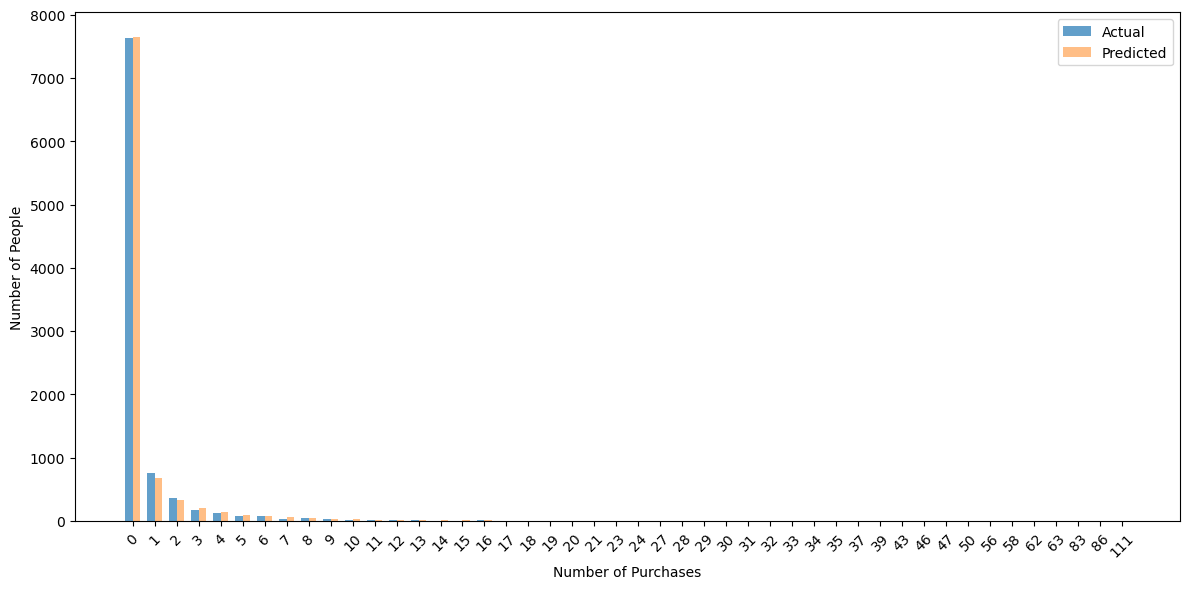

In [38]:
# Plotting Actual vs Predicted number of people against the number of purchases.
bar_width = 0.35
x = range(len(pur))

plt.figure(figsize=(12, 6))  # Increase the figure width to create more space

plt.bar([i - bar_width/2 for i in x], peo, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")

plt.xticks([i for i in x], pur, rotation=45)

plt.xlabel("Number of Purchases")
plt.ylabel("Number of People")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# NBD books02.csv

In [65]:
def nbd_b2(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [66]:
# Defining the log-likelihood function
def LL_nbd_b2(params, pur):
    n, a = params
    pmf = np.zeros(len(pur))
    ll_nbd = 0
    
    
    #ll_nbd = peo[0] * np.log(pmf[0])
    
    for k in range(len(pur)):
        if pur[k] == 0:
            pmf[k] = (a / (a + 1)) ** n
            ll_nbd += 1 * np.log(pmf[k])
        else:
            pmf[k] = nbd(k, n, a, pmf[k - 1])
            ll_nbd += 1 * np.log(pmf[k])
    
    return -ll_nbd

In [67]:
# Passing the parameters
params = np.array([1.0, 0.5])
pur = np.array(b2.qty)

In [68]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd = minimize(
    LL_nbd_b2,
    args=(pur),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

/var/folders/9n/6229qxsn2nb0ccgf0xrsgxb00000gp/T/ipykernel_1856/3401539121.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1
/var/folders/9n/6229qxsn2nb0ccgf0xrsgxb00000gp/T/ipykernel_1856/3401539121.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1
/var/folders/9n/6229qxsn2nb0ccgf0xrsgxb00000gp/T/ipykernel_1856/3401539121.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1


In [69]:
soln_nbd

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 1.000e+00  5.000e-01]
      nit: 0
      jac: [       nan        nan]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>